# Mini Project 1: Training the Network

Now we will investigate training our network in order to answer the questions we had in the manual.

In [1]:
# Imports.
import os
import numpy as np
import math as m
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
%matplotlib inline

We begin by reading in the input data. The input data are initially named image files of white Helvetica font characters, on a black background. The image files will act as masks in order to generate our set of input images on the fly. Helvetica is a very standard font used in the UK, so to reduce computation time I will only sample this font for now. Since food packaging comes in many different colours, one can simulate this by using a variety of different background colours.

This is tedious to do in MS Paint, so instead I use the PIL.Image library to generate images with different backgrounds. Consider iterating through the greyscale values from $0$ to $255$. Once the greyscale background goes past the halfway mark, I change the character colour from white to black. To reduce the input data size, I iterate in steps of ~5.

In [2]:
# These are the sizes of the pixel grid.
N_X = 60
N_Y = 60

def im_to_grey(im):
    '''
    Takes the input image and returns
    a flattened numpy array of the greyscale pixel values.
    
    Inputs:
    im - a PIL.Image file.
    
    Outputs:
    pixel_list - flattened numpy array of the greyscale pixels.
    '''
    pixels = im.load()
    pixel_list = []
    for j in range(0,N_X):
        for k in range(0,N_Y):
            # Converting each pixel to greyscale.
            pixel_list.append(sum(pixels[j,k][0:3])/(3.0*255.0))
    return np.array(pixel_list)

In [3]:
# These black and white images are used to generate
# our training set via composition methods in PIL.Image.
im_black = Image.new(mode = 'RGB', size = (N_X,N_Y), color = 'black')
im_white = Image.new(mode = 'RGB', size = (N_X,N_Y), color = 'white')
# Max. no. of greyscale backgrounds that we use.
bckgrd_max = 50


# Setting up the dataframe of training data.
train_data = pd.DataFrame(columns = ['mask_filename', 'pixels', 'input', 'width', 'height', 'background_value', 'foreground_value'])
# Providing the path to the training data.
train_path = os.getcwd()
train_path += "\\training_images\\Helvetica\\"
pixel_inputs = []

# Now we will append the training data to the dataframe.
i = 0
for root, dirs, files in os.walk(train_path):
    for file in files:
        # Saving the filename of the current file
        # to the current index.
        # We will open the file and take the relevant
        # image metadata, and add it to the appropriate columns.
        with Image.open(root + file) as im:
            # Iterating over intermediate grey background values.
            # This will generate extra training images from our mask files.
            for pixel_background_it in range(0,bckgrd_max+1):
                pixel_background = int(np.ceil(pixel_background_it*(255/bckgrd_max)))
                if pixel_background <= 127:
                    train_data.loc[i,'foreground_value'] = 255
                else:
                    train_data.loc[i,'foreground_value'] = 0
                train_data.loc[i,'background_value'] = pixel_background
                train_data.loc[i,'mask_filename'] = file
                if pixel_background == 0:
                    # Input is the input of the ANN.
                    pixel_inputs.append(im_to_grey(im = im))
                else:
                    with Image.new(mode = 'RGB',
                                     size = (N_X,N_Y),
                                     color = (pixel_background,pixel_background,pixel_background)) as im_2:
                        with im.convert(mode = 'L') as im_mask:
                            if pixel_background <= 127:
                                with Image.composite(image1 = im_white, image2 = im_2, mask = im_mask) as im_3:
                                    pixel_inputs.append(im_to_grey(im = im_3))
                            else:
                                with Image.composite(image1 = im_black, image2 = im_2, mask = im_mask) as im_3:
                                    pixel_inputs.append(im_to_grey(im = im_3))

                # Some image metadata.
                train_data.loc[i,'width'] = im.width
                train_data.loc[i,'height'] = im.height
                i += 1
        
# Now we will convert the filenames to the letters.
# In the filenames, the ( character is used to represent
# a lowercase letter.
train_data['char'] = train_data['mask_filename'].apply(func = (lambda x : x[1] if x[0] == '(' else x[0]))
train_data[['mask_filename','char']]

mask_filename char
0     (a_Helvetica.png    a
1     (a_Helvetica.png    a
2     (a_Helvetica.png    a
3     (a_Helvetica.png    a
4     (a_Helvetica.png    a
...                ...  ...
3157   Z_Helvetica.png    Z
3158   Z_Helvetica.png    Z
3159   Z_Helvetica.png    Z
3160   Z_Helvetica.png    Z
3161   Z_Helvetica.png    Z

[3162 rows x 2 columns]

Now we can create the inputs and outputs from train_data frame.

In [4]:
# X values.
X_keras = np.asarray(pixel_inputs).astype('float32')

In [5]:
# y_true.
y_keras = np.asarray(pd.get_dummies(data = train_data['char']).values).astype('float32')

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_keras,
                                                    y_keras,
                                                    test_size=0.33,
                                                    random_state=42)

In [7]:
# Once we have the train and test sets,
# we no longer need the full set of data.
del X_keras, y_keras, train_data

### Training with a dense Keras network - custom vs. random weights.
I will first check the results of training a dense Keras ANN, since it is the easiest to setup. I will provide the same number of nodes as I have planned for our custom network, which is $46 \times 2$ in the first hidden layer ($46$ nodes each for black and white characters), and of course $62$ for the output layer which corresponds to a vector which represents the characters.

In [8]:
# Creating a sequential model with one hidden layer.
n_nodes_layer_1 = 46*2
keras_model = Sequential()
keras_model.add(Dense(units = n_nodes_layer_1, input_dim = N_X*N_Y, activation = 'relu', name = 'hidden_layer_1'))
keras_model.add(Dense(units = 62, activation = 'softmax', name = 'output_layer'))
keras_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                                                         loss = 'categorical_crossentropy',
                                                         metrics = ['accuracy'])

In [9]:
keras_model.fit(x = X_train, y = y_train, validation_data = (X_test,y_test), epochs = 100)

Epoch 1/100
67/67 [==============================] - 1s 4ms/step - loss: 4.1230 - accuracy: 0.0321 - val_loss: 3.9766 - val_accuracy: 0.0536
Epoch 2/100
67/67 [==============================] - 0s 3ms/step - loss: 3.7231 - accuracy: 0.1095 - val_loss: 3.4091 - val_accuracy: 0.1609
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 3.0814 - accuracy: 0.2743 - val_loss: 2.7215 - val_accuracy: 0.3333
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 2.3719 - accuracy: 0.4561 - val_loss: 2.0360 - val_accuracy: 0.5508
Epoch 5/100
67/67 [==============================] - 0s 3ms/step - loss: 1.8377 - accuracy: 0.5788 - val_loss: 1.6310 - val_accuracy: 0.6322
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 1.4272 - accuracy: 0.6700 - val_loss: 1.2698 - val_accuracy: 0.7126
Epoch 7/100
67/67 [==============================] - 0s 3ms/step - loss: 1.1190 - accuracy: 0.7370 - val_loss: 0.9760 - val_accuracy: 0.7720
Epoch 8/100
6

Epoch 59/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 60/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0022 - val_accuracy: 1.0000
Epoch 61/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 62/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 63/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 64/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 65/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 

In [10]:
# Deletes the random network for better memory management.
#del keras_model

Now, I will use the function I made in an earlier notebook in order to convert the image files for the nodes into weight arrays.

In [11]:
# The cyan unit vector is aligned along the x-axis, therefore red is
# aligned along the negative x-axis.
# The green and blue unit vectors are 300 and 60 degrees from the
# positive x-axis respectively.
THETA = m.radians(60.0)
RED_UNIT_VEC = np.array([-1,0])
GREEN_UNIT_VEC = np.array([np.cos(5.0*THETA),np.sin(5.0*THETA)])
BLUE_UNIT_VEC = np.array([np.cos(THETA),np.sin(THETA)])
del THETA

# Porting over the pixel_to_weight function for our custom ANN.
def pixel_to_weight(pixel_colours, tol_var = 1E-6):
    '''
    Coverts a single pixel tuple into a weight for the initial weighting.
    Acceptable colours are cyan for positive weights, red for negative
    weights, and black for 0.

    This function converts the red, green and blue values into 2D
    vectors, where the x-axis is aligned along the cyan axis. So purely
    red maps to a vector of (-1,0), and purely cyan to (1,0).
    The weight is taken as the value of the x-component, provided that the
    absolute value of the x-component is greater than the tolerance tol_var.
    '''

    global RED_UNIT_VEC, GREEN_UNIT_VEC, BLUE_UNIT_VEC

    # The colour vector is the sum of the colour components.
    colour_vec = (pixel_colours[0]*RED_UNIT_VEC + \
    pixel_colours[1]*GREEN_UNIT_VEC + \
    pixel_colours[2]*BLUE_UNIT_VEC) \
    /(255.0)

    # The weights will not change if the baseline level is too
    # low in absolute value, so we pick a tolerance. If the
    # absolute value of the x component is less than the tolerance,
    # then we assign the weight to the tolerance multiplied by the
    # sign of the x component. Else, we just assign the weight to the
    # x component.
    if abs(colour_vec[0]) > tol_var:
        return colour_vec[0]
    sign_var = np.sign(colour_vec[0])
    if sign_var == 0:
        sign_var = 1
    return sign_var*tol_var

In [12]:
# Creating a sequential model with one hidden layer.
keras_model_cust = Sequential()
keras_model_cust.add(Dense(units = n_nodes_layer_1, input_dim = N_X*N_Y, activation = 'relu', name = 'hidden_layer_1'))
keras_model_cust.add(Dense(units = 62, activation = 'softmax', name = 'output_layer'))
keras_model_cust.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

# Loading in our custom weights to see if this introduces better
# calculations.
str_root = os.getcwd()
n_nodes_prev = 3600
weights = []
layer_weights = []
for node in range(0,n_nodes_layer_1):
    # Custom weights are only applied to the first
    # hidden layer.
    node_weights = []
    try:
        in_filename = str_root + '\\ini_weights\\test_1\\node_' + str(node) + '.png'
        # Now converting each pixel in the node image to a weight.
        with Image.open(fp = in_filename, mode = "r") as in_image:
            in_pixels = in_image.load()
            for x_val in range(N_X):
                for y_val in range(N_Y):
                    node_weights.append(pixel_to_weight(pixel_colours = in_pixels[x_val,y_val],
                                                   tol_var = 1E-3))
    except FileNotFoundError:
        print('File not found, assigning random weights.')
        node_weights = np.random.rand(n_nodes_prev)
    weights.append(node_weights)

# The layer_weights object consists of the weights
# and biases.
layer_weights.append(np.array(weights, dtype = 'object').transpose())
layer_weights.append(np.zeros(n_nodes_layer_1))

# Now setting the custom weights.
for layer in keras_model_cust.layers:
    if layer.name == 'hidden_layer_1':
        layer.set_weights(layer_weights)

In [13]:
keras_model_cust.fit(x = X_train, y = y_train, validation_data = (X_test,y_test), epochs = 100)

Epoch 1/100
67/67 [==============================] - 0s 3ms/step - loss: 12.1861 - accuracy: 0.0387 - val_loss: 4.5971 - val_accuracy: 0.1226
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 3.4031 - accuracy: 0.2559 - val_loss: 2.5609 - val_accuracy: 0.3707
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 1.9101 - accuracy: 0.5571 - val_loss: 1.4602 - val_accuracy: 0.6619
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 1.0291 - accuracy: 0.7923 - val_loss: 0.6762 - val_accuracy: 0.8793
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.4521 - accuracy: 0.9240 - val_loss: 0.2607 - val_accuracy: 0.9559
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1916 - accuracy: 0.9764 - val_loss: 0.1660 - val_accuracy: 0.9693
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1109 - accuracy: 0.9825 - val_loss: 0.0960 - val_accuracy: 0.9895
Epoch 8/100


In [14]:
# Deletes the custom network for better memory management.
#del keras_model_cust

So far, we see that the custom network is faster in reaching a training and validation accuracy of $1$, implying that the initial weights are closer to the most accurate network configuration. So what do the weights look like after training for our custom and random networks?

In [15]:
def weights_to_pixels(weights, max_weight = 1.0):
    '''
    This is a function that takes in the weights of a single node in
    the first hidden layer, and changes them into an image. This should
    be used to test the output of the pixel_to_weight() method above,
    but it can also be used to generate pictures of the distribution of
    weights after the ANN has converged.
    '''

    global N_X, N_Y

    # On input, weights are a 1D array or list. We can reshape it into
    # a 2D array in order for easier indexing.
    weights_2d = np.array(weights).reshape((N_X,N_Y))
    with Image.new('RGB', (N_X,N_Y), 'white') as out_image:
        pixels_var = out_image.load()
        # Now iterating over the width and height.
        for i in range(N_X):
            for j in range(N_Y):
                pixels_var[i,j] = weight_to_pixel(weight_var = weights_2d[i,j], max_weight = max_weight)

        return out_image


def weight_to_pixel(weight_var, accur_var = 14, max_weight = 1.0):
    '''
    This function converts a singular weight value to a pixel.
    Rounding is necessary to map cyan to the proper pixel value.
    accur_var controls the accuracy of the round() method.
    '''

    # If the weight is less than or equal to zero, then we take the
    # absolute value of that weight in terms of red.
    # If the weight is greater than zero, then we take the value of the
    # weight in terms of cyan.
    if weight_var <= 0:
        return (int(255.0*abs(round(weight_var,accur_var))/max_weight),0,0)
    return (0,int(255.0*round(weight_var,accur_var)/max_weight),\
                int(255.0*round(weight_var,accur_var)/max_weight))

<ipython-input-16-46823b1d1b82>:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_X,N_Y,i).set_ylabel('y pixel')
<ipython-input-16-46823b1d1b82>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_X,N_Y,i).set_title(title_str)
<ipython-input-16-46823b1d1b82>:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future ve

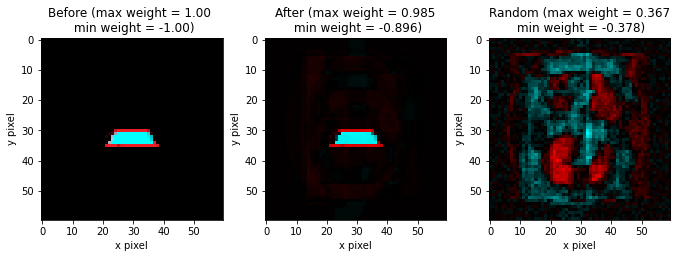

In [16]:
# This code block plots the before training and after training
# weights for the custom network, as well as the weights for the
# random network after training.
node = 0
max_abs_weight_flag = True
in_filename = str_root + '\\ini_weights\\test_1\\node_' + str(node) + '.png'
plt.figure(facecolor = 'white', figsize = (240,240))
for i in range(1,4):
    plt.subplot(N_X,N_Y,i).set_xlabel('x pixel')
    plt.subplot(N_X,N_Y,i).set_ylabel('y pixel')
    if i == 1:
        title_str = 'Before (max weight = 1.00 \n min weight = -1.00)'
        plt.subplot(N_X,N_Y,i).set_title(title_str)

        try:
            with Image.open(fp = in_filename, mode = "r") as in_image:
                plt.imshow(in_image)
        except FileNotFoundError:
            in_filename = str_root + '\\ini_weights\\test_1\\node_' + str(0) + '.png'
            with Image.open(fp = in_filename, mode = "r") as in_image:
                plt.imshow(in_image)

    elif i == 2:
        for layer_cust in keras_model_cust.layers:
            if layer_cust.name == 'hidden_layer_1':
                weights = layer_cust.weights[0].numpy().transpose()[node]
                max_weight = np.amax(a = weights)
                min_weight = np.amin(a = weights)
                max_weight = round(max_weight,3)
                min_weight = round(min_weight,3)
                if max_abs_weight_flag:
                    max_abs_weight = np.amax(a = [max_weight,abs(min_weight)])
                else:
                    max_abs_weight = 1.0       
                title_str = 'After (max weight = ' + str(max_weight) + '\n min weight = ' + str(min_weight) + ')'
                plt.subplot(N_X,N_Y,i).set_title(title_str)
                plt.imshow(weights_to_pixels(weights = weights))
    else:
        for layer in keras_model.layers:
            if layer.name == 'hidden_layer_1':
                weights = layer.weights[0].numpy().transpose()[node]
                max_weight = np.amax(a = weights)
                min_weight = np.amin(a = weights)
                if max_abs_weight_flag:
                    max_abs_weight = np.amax(a = [max_weight,abs(min_weight)])
                else:
                    max_abs_weight = 1.0
                max_weight = round(max_weight,3)
                min_weight = round(min_weight,3)
                title_str = 'Random (max weight = ' + str(max_weight) + '\n min weight = ' + str(min_weight) + ')'
                plt.subplot(N_X,N_Y,i).set_title(title_str)
                plt.imshow(weights_to_pixels(weights = weights, max_weight = max_abs_weight))

For the custom network, the weights barely change, indicating that they are close to convergence. For some nodes, there are smaller background structures that appear, but they are much smaller in value relative to the initial weights.

The random network exhibits interesting behaviour. For some of the nodes, the weights are sporadic and entropic, and have small absolute maximum and minimum values. However, for some nodes we can see very specialised structures and patterns appear. There are many more of these high entropy nodes compared to these low entropy (or patterned) nodes. One possible reason for this is the random network has managed to organise the $92$ custom nodes in a way that parallelises their function. For example, node $0$ in the custom network looks for the horizontal bridge in the letter A (amongst other bridges). But if a character does not have this bridge, then other characteristic nodes corresponding to features in these 'bridgeless' characters can be checked for in node $0$.

This is very complicated and unintuitive for us to visually organise, but it could mean that the $92$ node random network may use more nodes than is actually needed. This means that for a fair comparison, we should reduce the number of nodes and compare the custom network to a smaller random network.

Below is a code that plots all $92$ nodes, which can be used to manually count the number of patterned nodes.

<ipython-input-17-731931f4b7e3>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_X,N_Y,i).set_ylabel('y pixel')
<ipython-input-17-731931f4b7e3>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(N_X,N_Y,i).set_title(title_str)
<ipython-input-17-731931f4b7e3>:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future ver

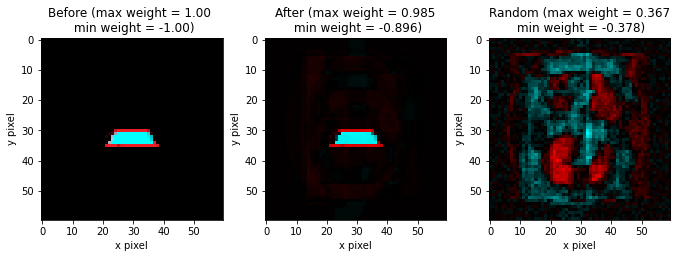

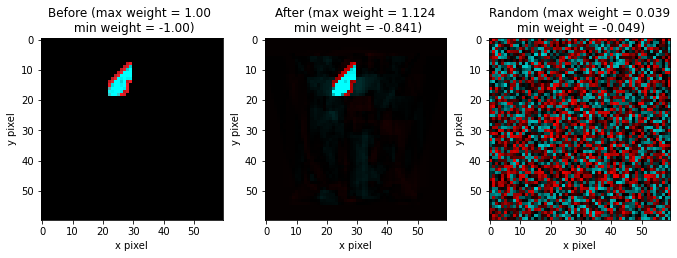

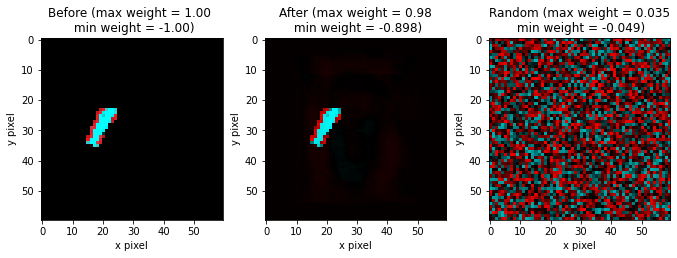

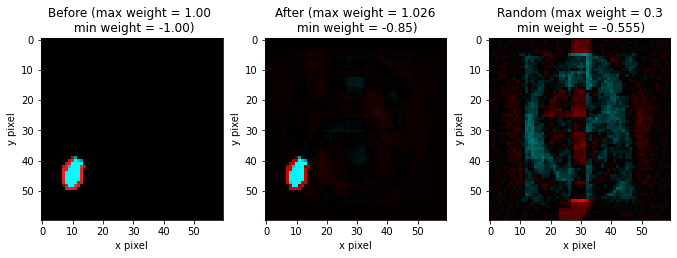

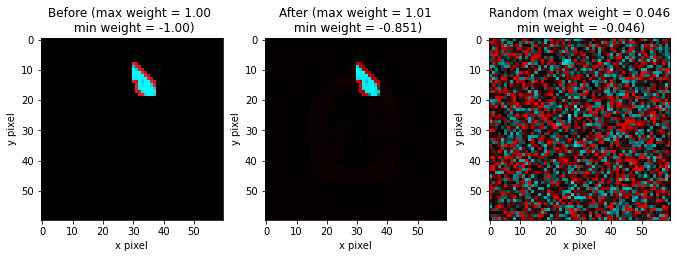

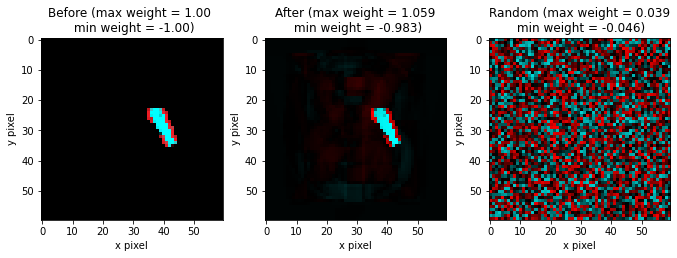

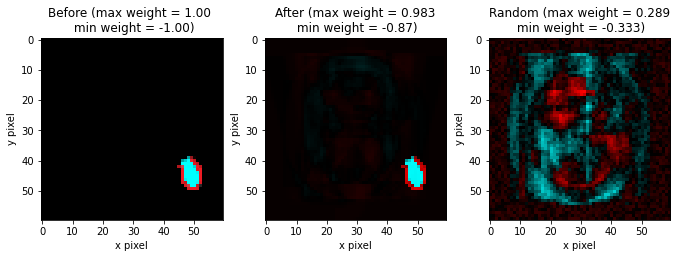

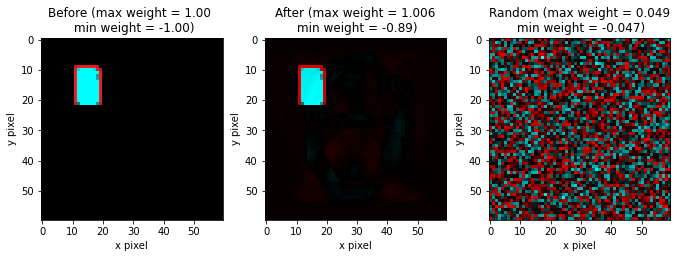

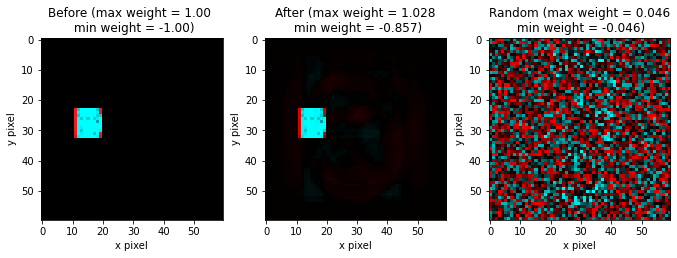

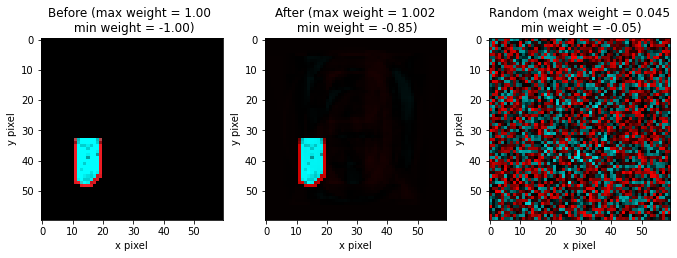

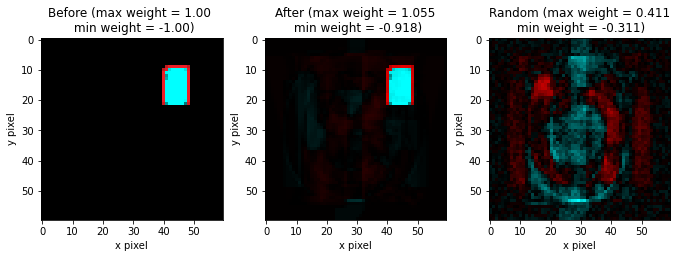

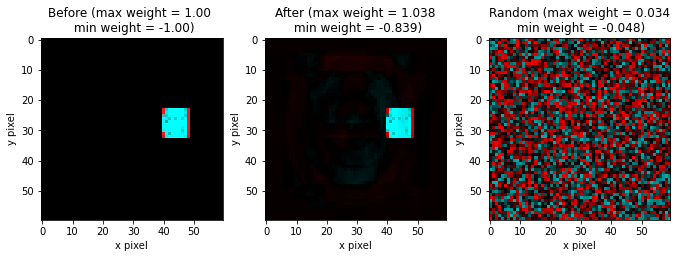

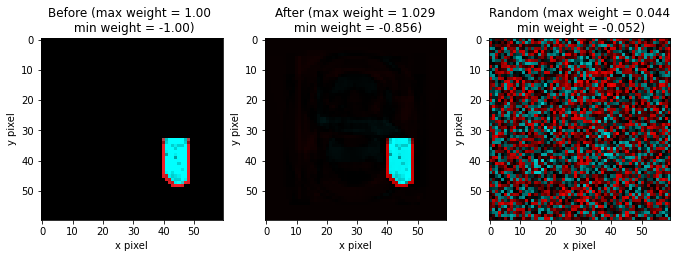

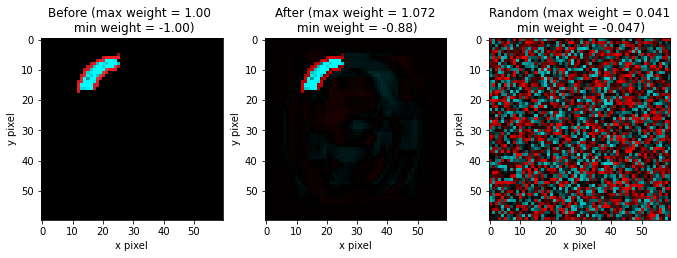

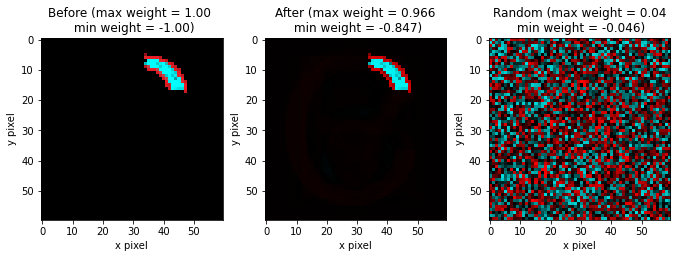

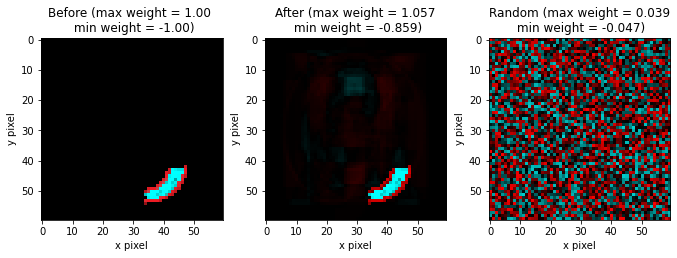

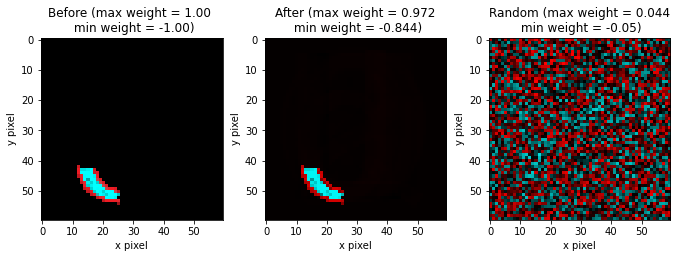

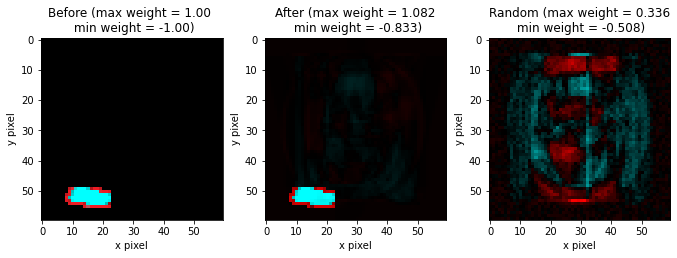

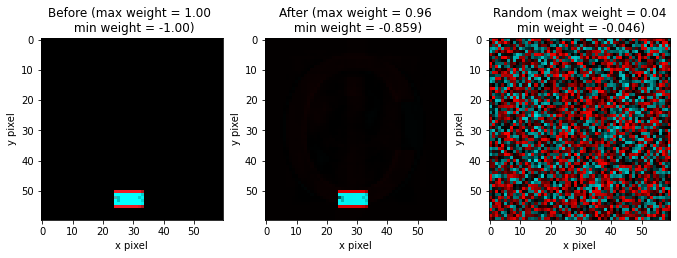

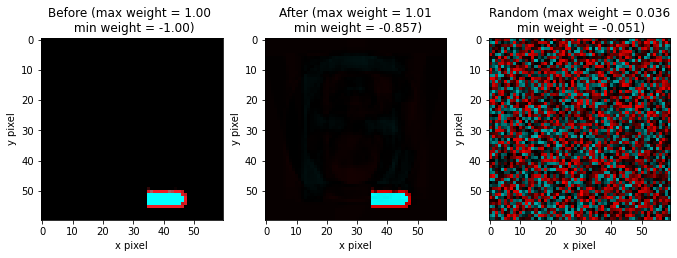

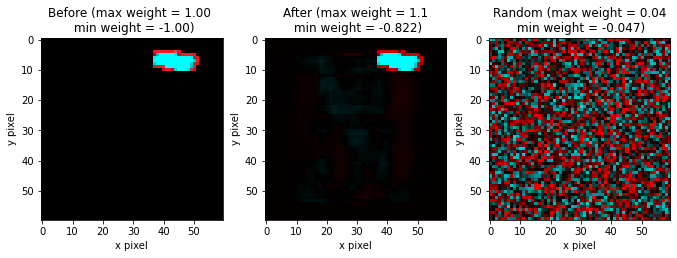

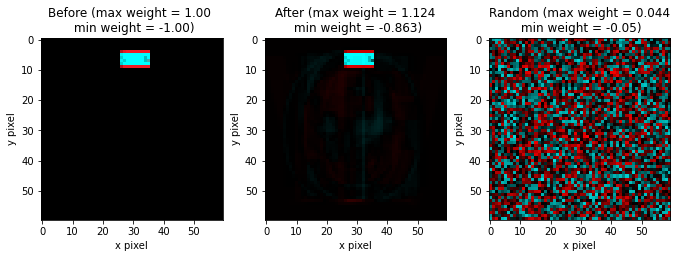

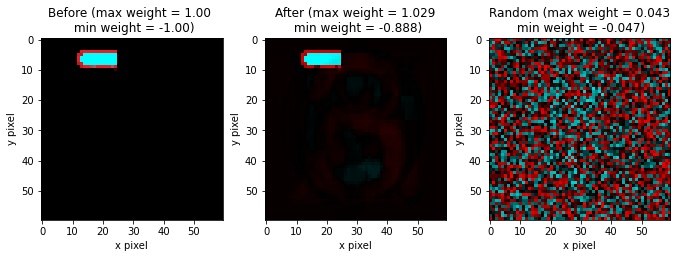

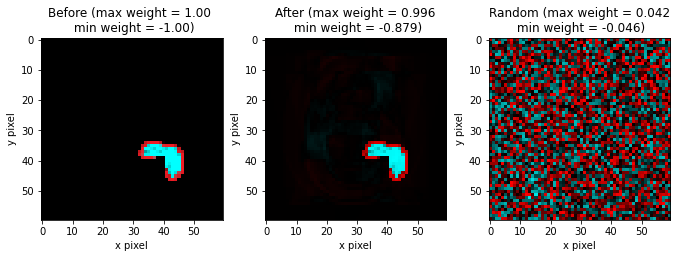

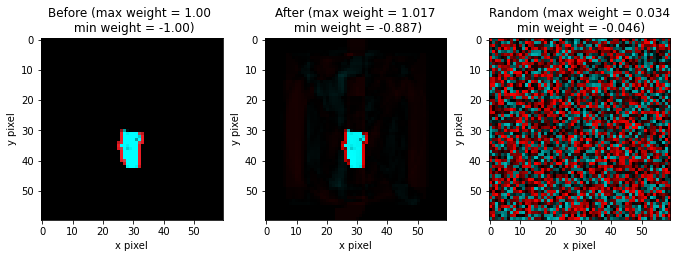

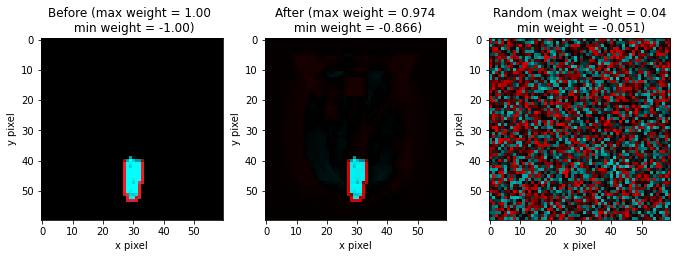

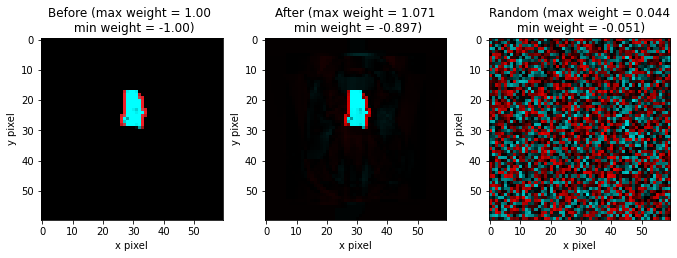

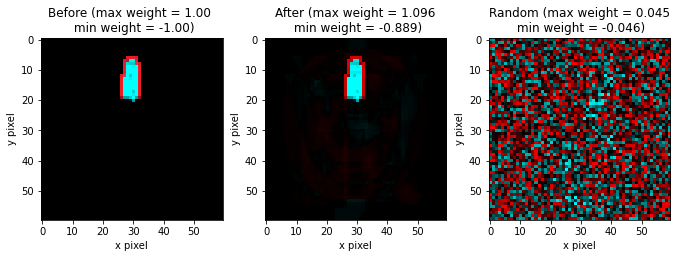

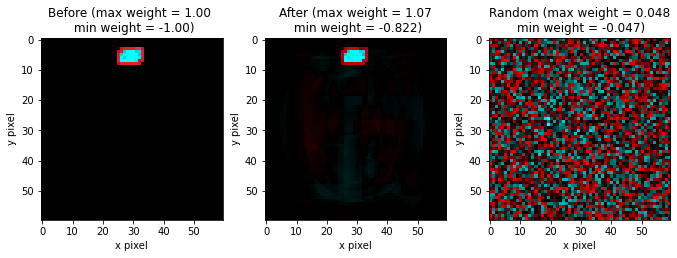

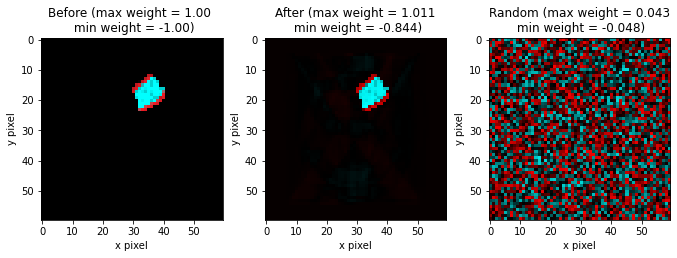

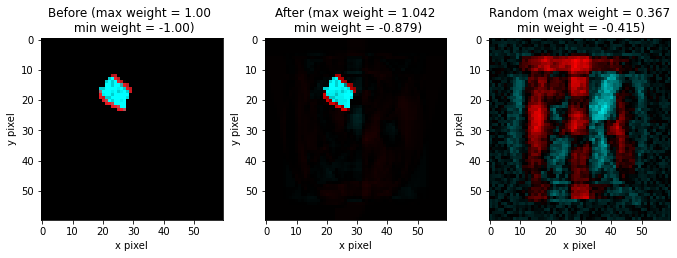

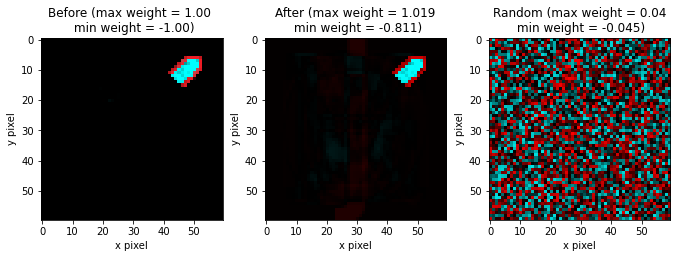

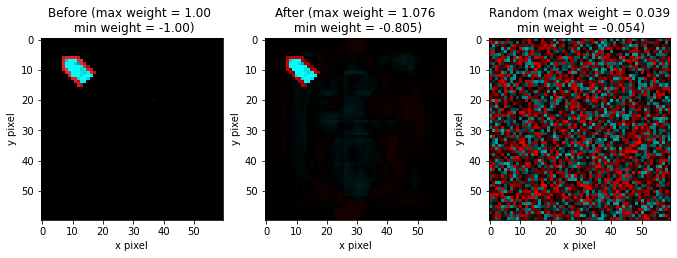

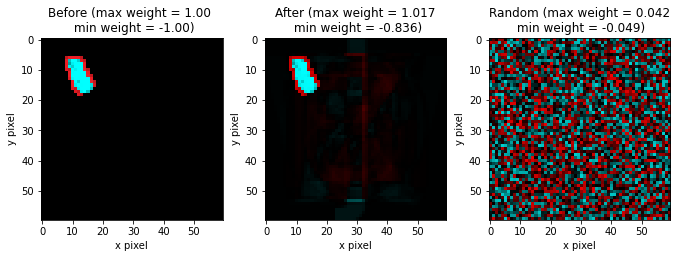

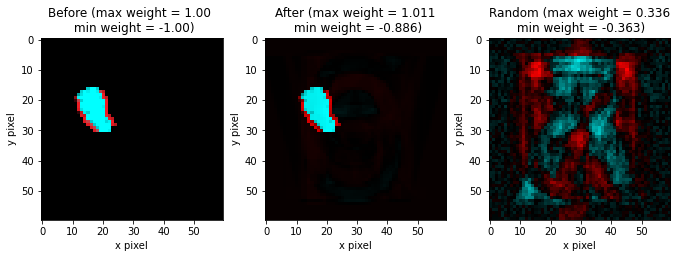

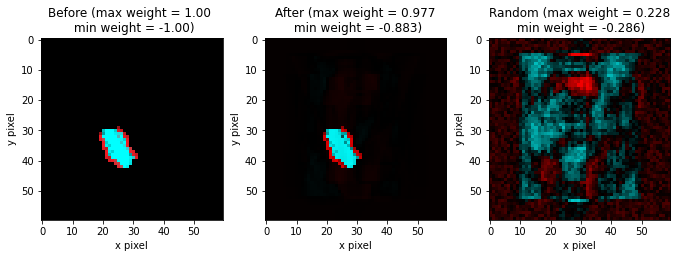

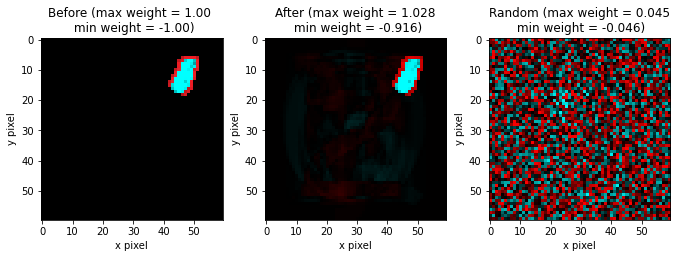

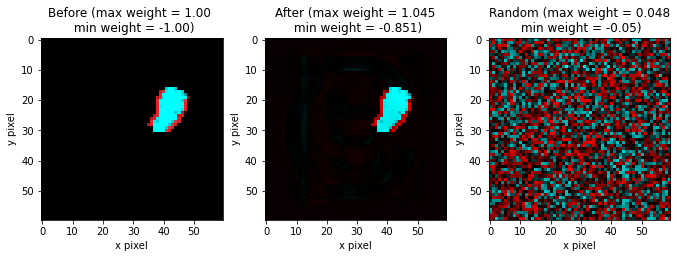

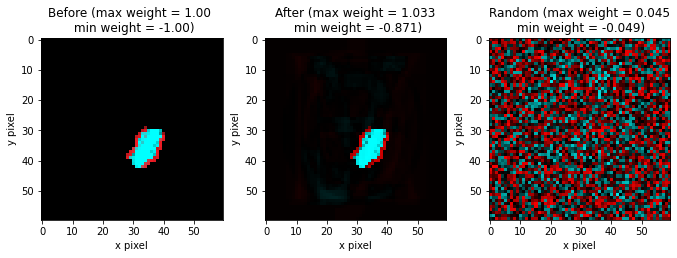

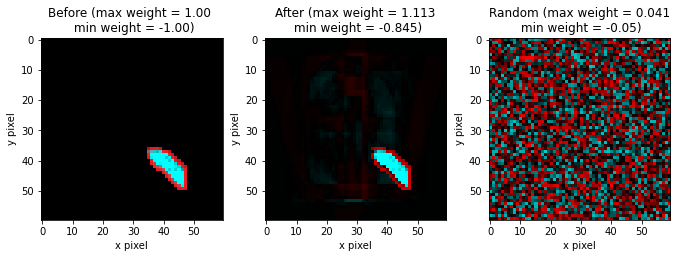

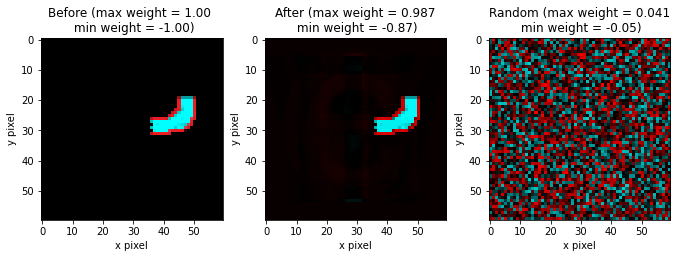

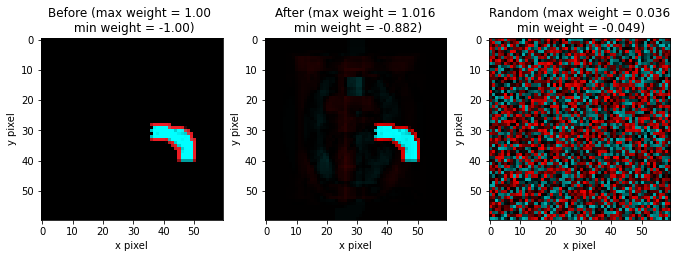

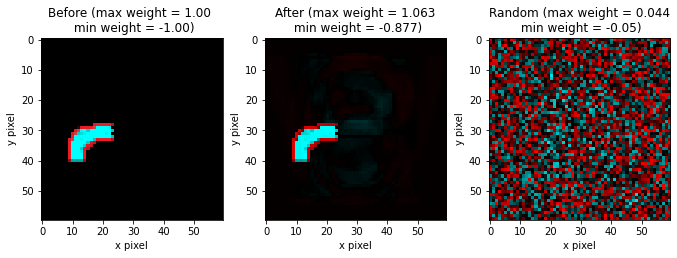

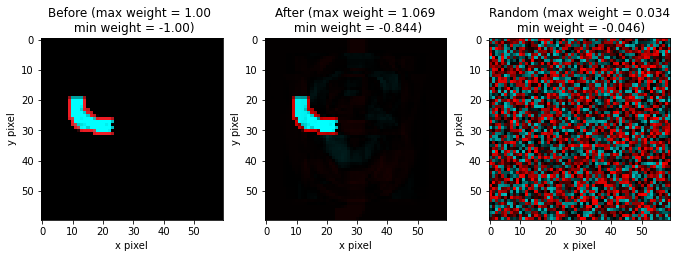

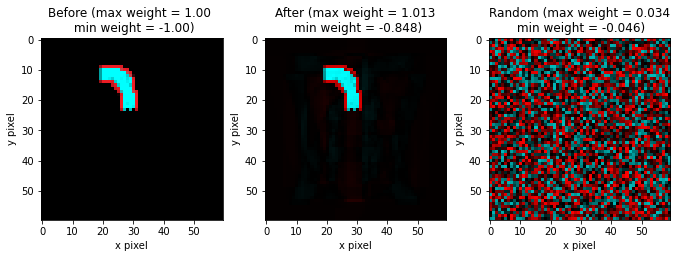

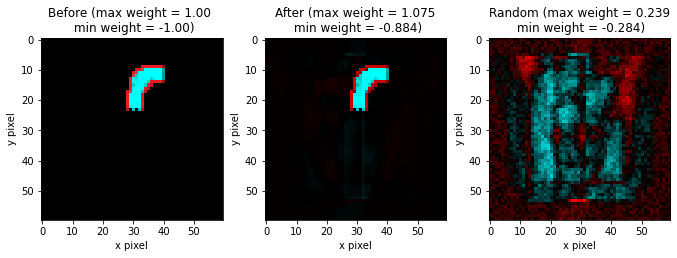

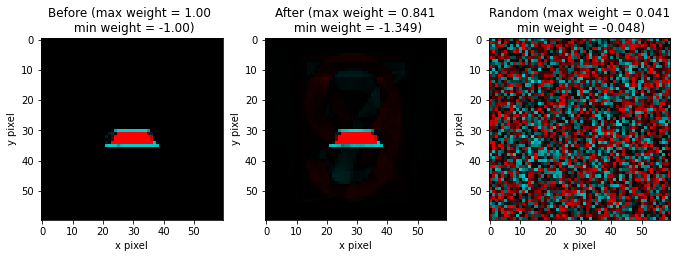

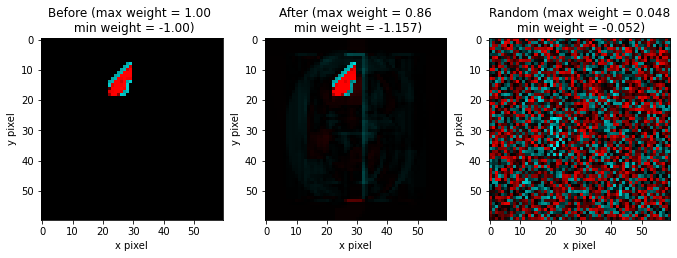

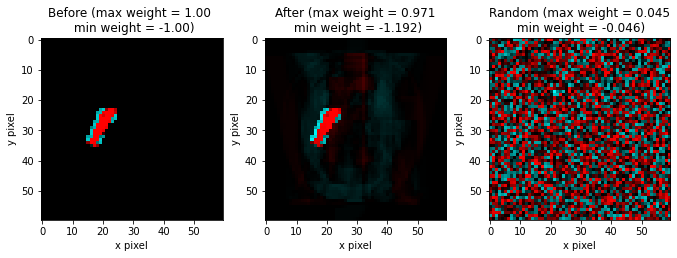

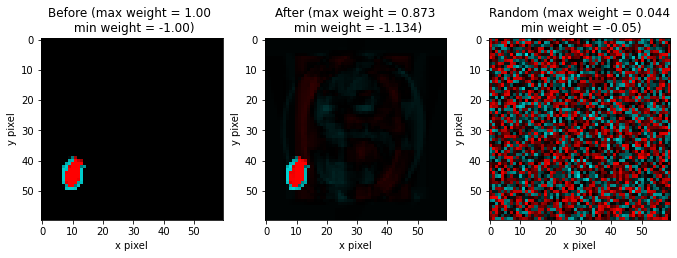

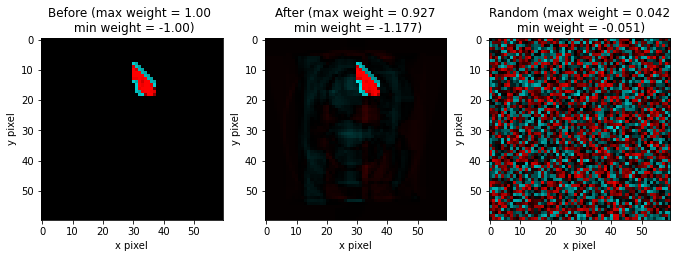

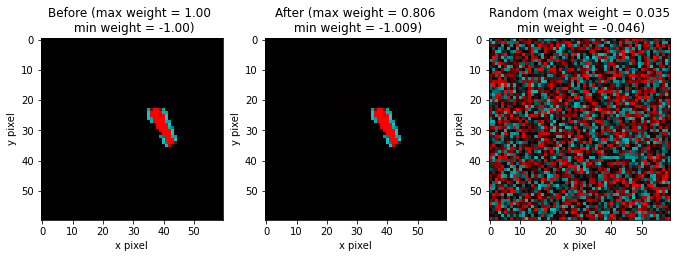

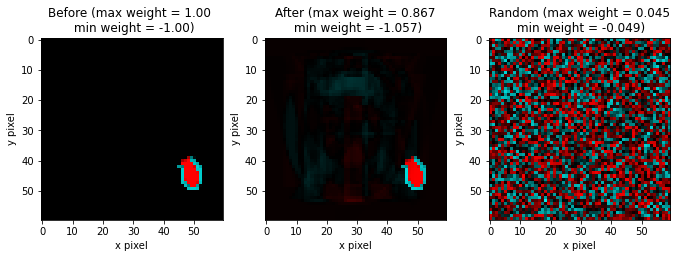

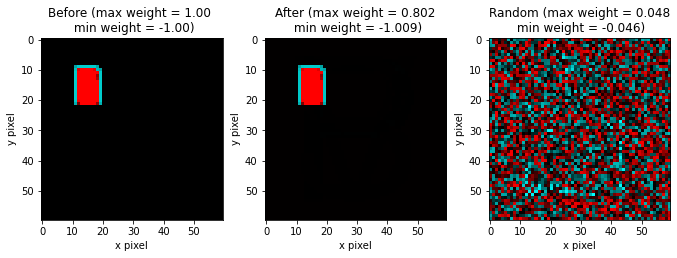

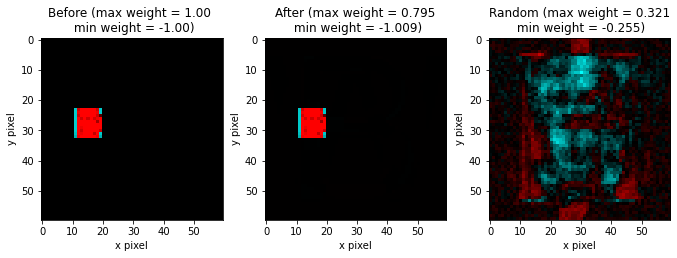

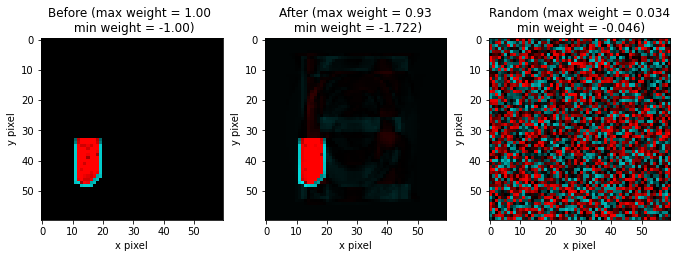

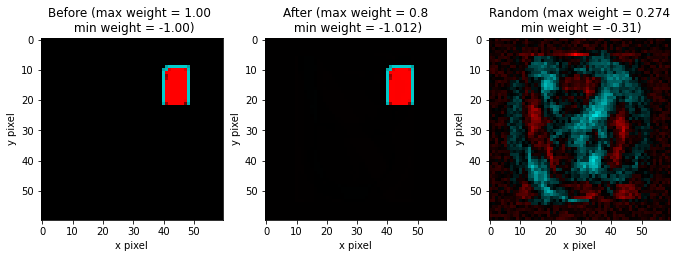

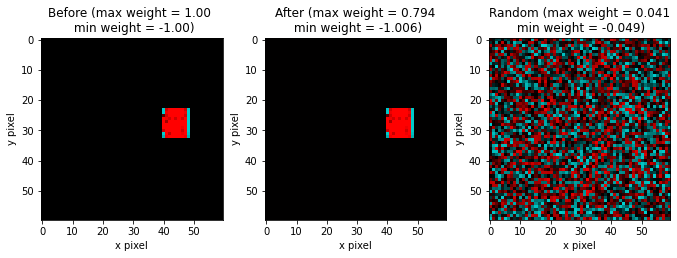

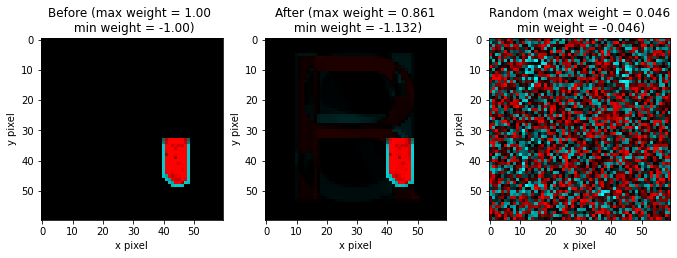

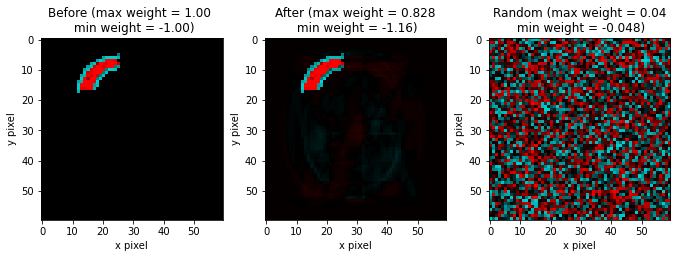

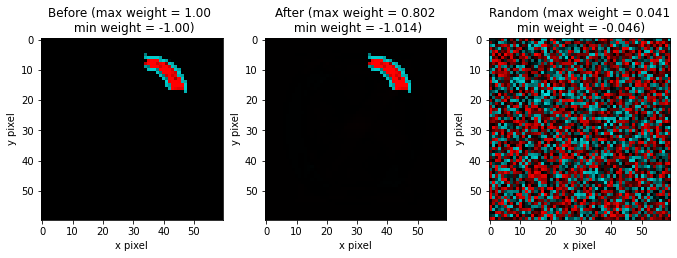

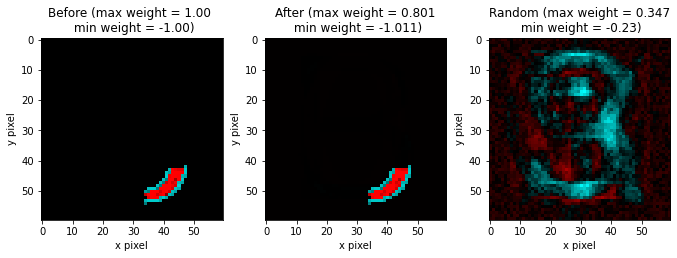

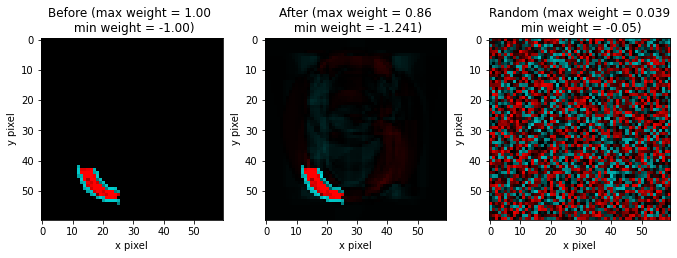

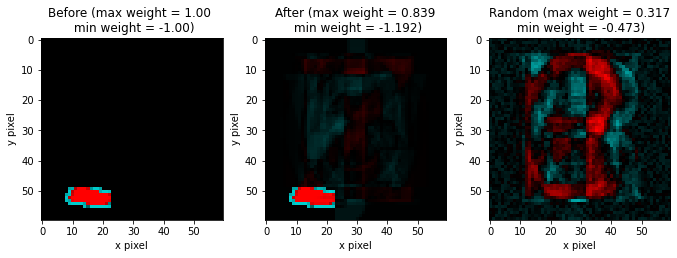

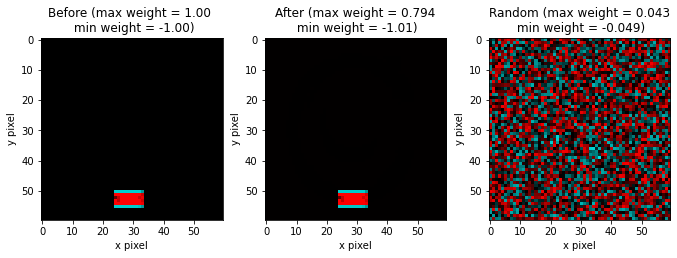

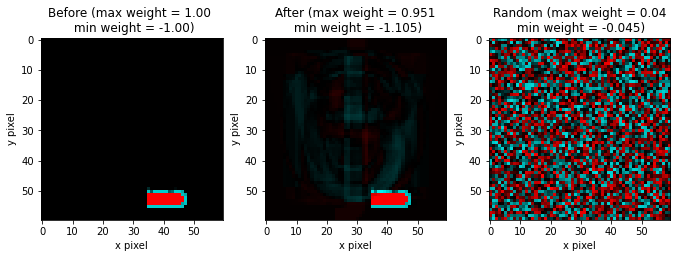

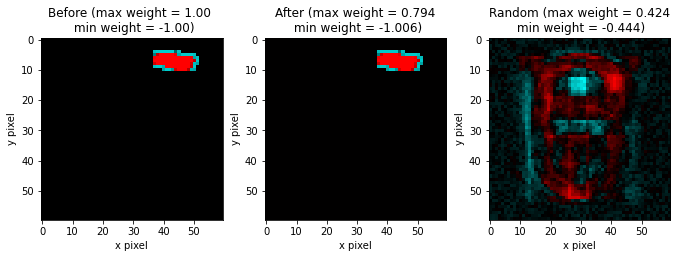

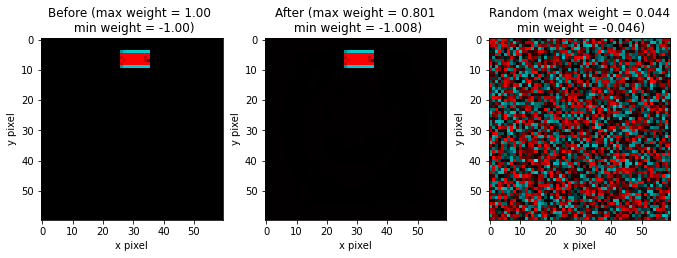

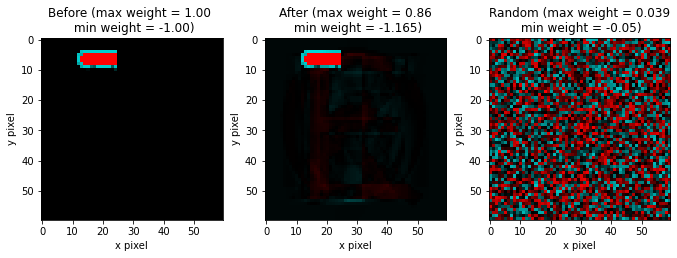

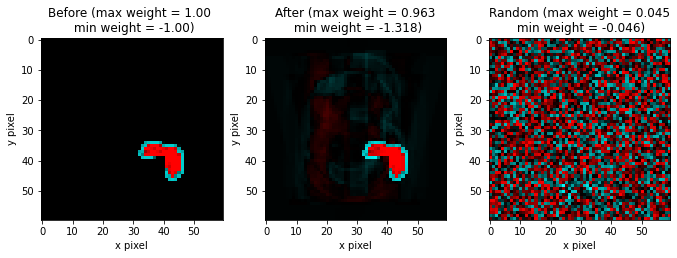

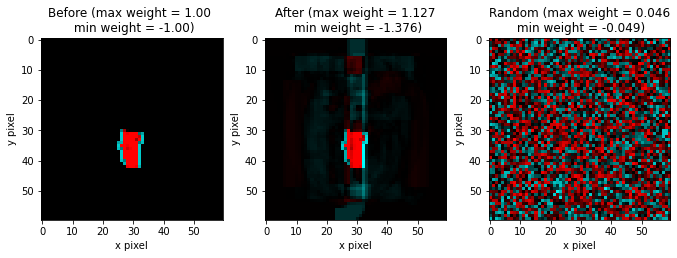

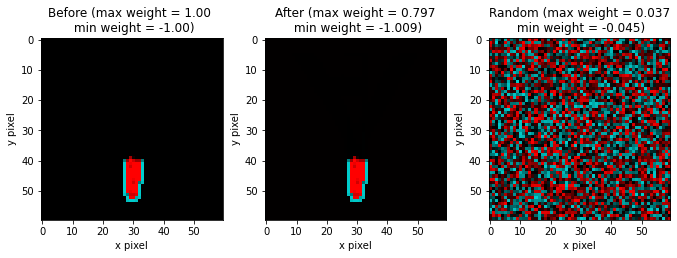

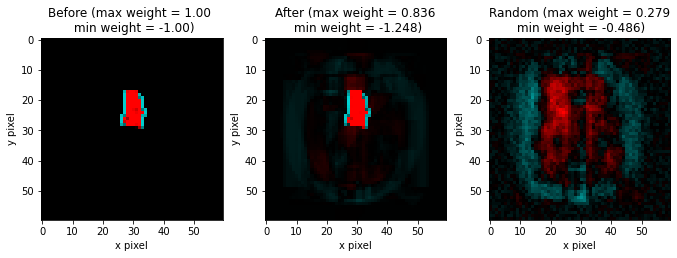

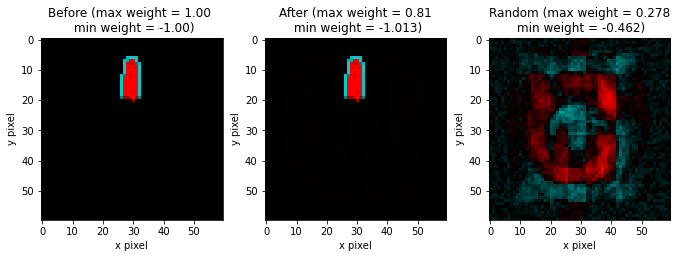

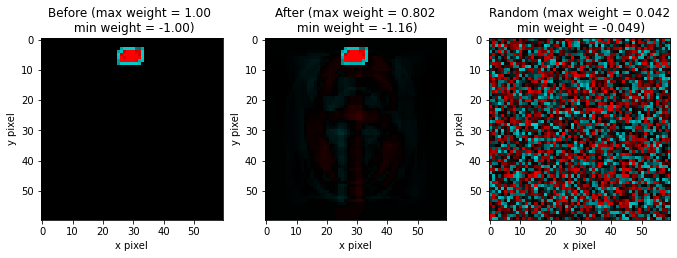

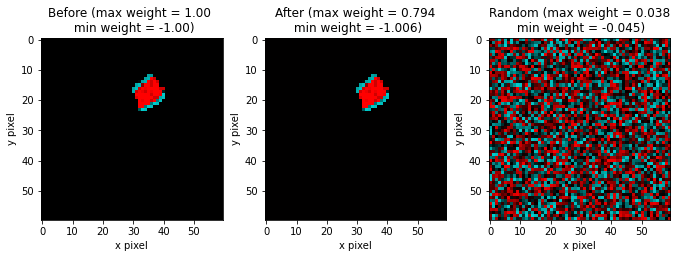

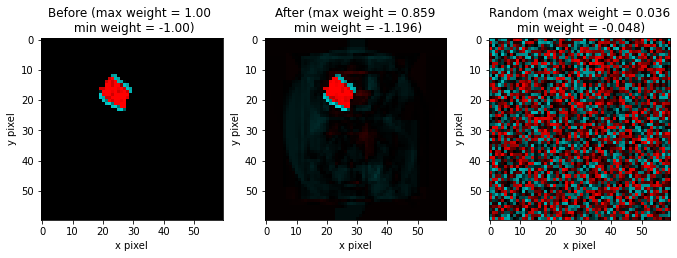

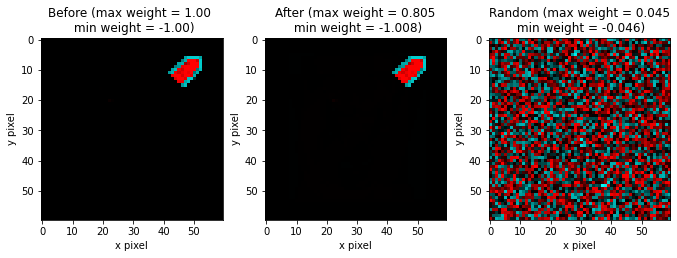

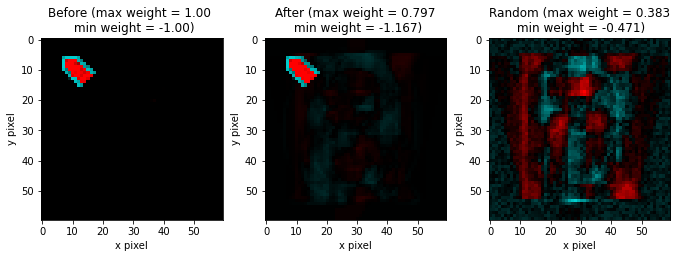

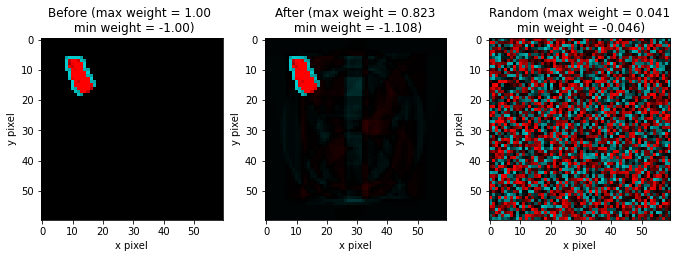

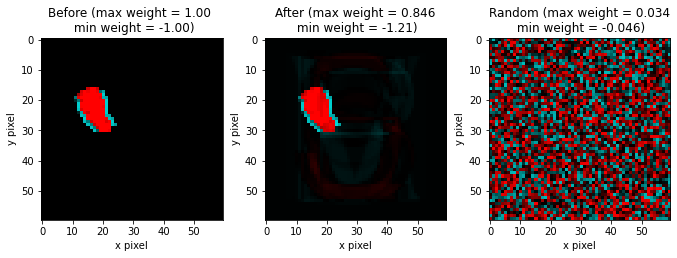

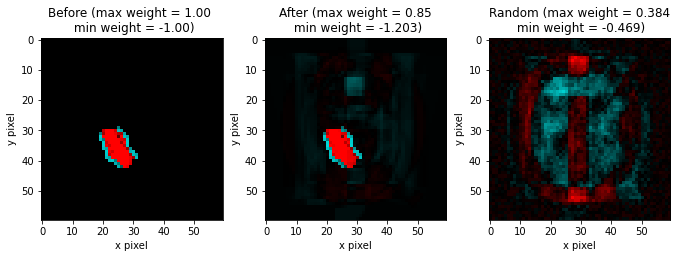

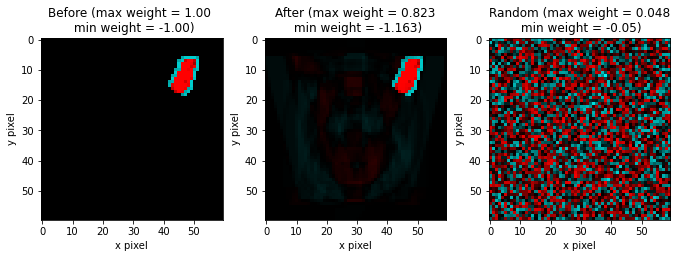

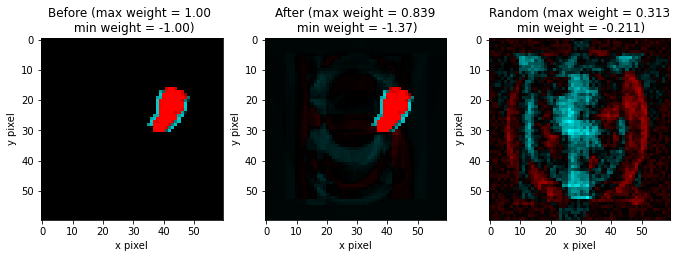

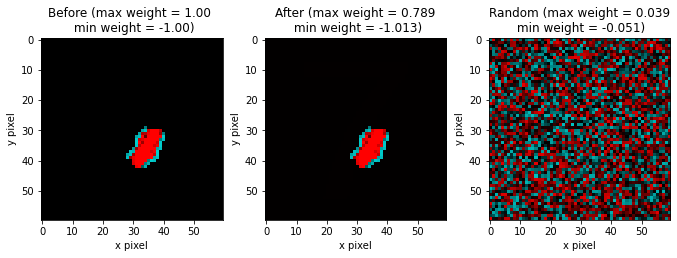

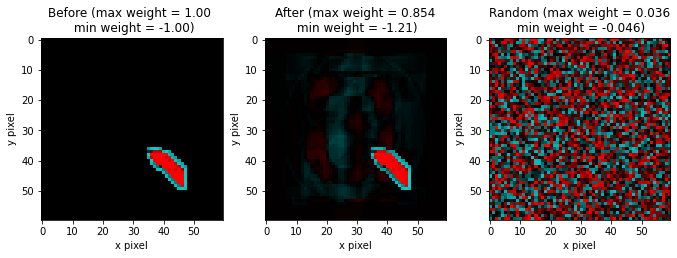

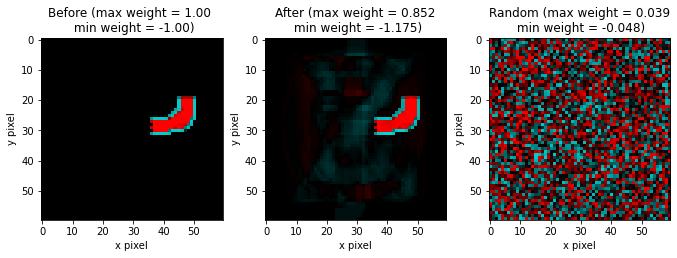

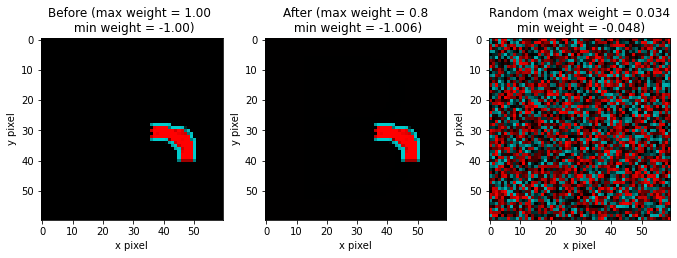

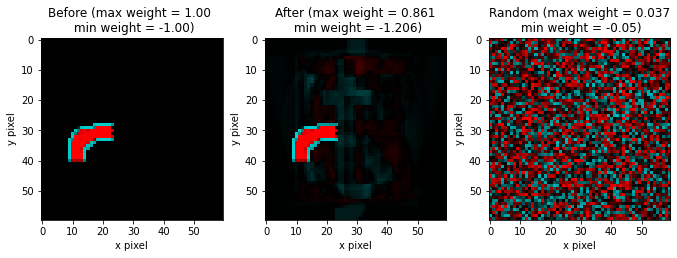

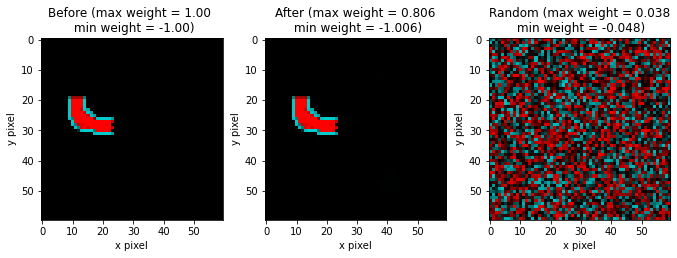

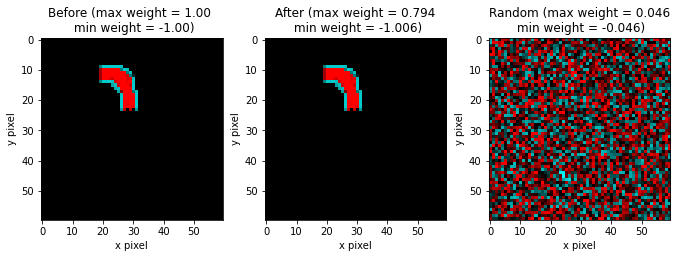

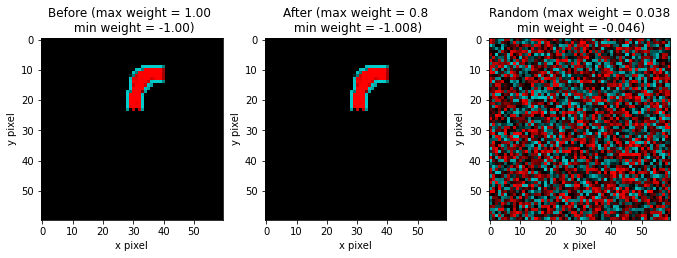

In [17]:
# This code will plot all 92 nodes.
max_abs_weight_flag = True
for node in range(0,n_nodes_layer_1):
    in_filename = str_root + '\\ini_weights\\test_1\\node_' + str(node) + '.png'
    plt.figure(facecolor = 'white', figsize = (240,240))
    for i in range(1,4):
        plt.subplot(N_X,N_Y,i).set_xlabel('x pixel')
        plt.subplot(N_X,N_Y,i).set_ylabel('y pixel')
        if i == 1:
            title_str = 'Before (max weight = 1.00 \n min weight = -1.00)'
            plt.subplot(N_X,N_Y,i).set_title(title_str)


            with Image.open(fp = in_filename, mode = "r") as in_image:
                plt.imshow(in_image)
        elif i == 2:
            for layer_cust in keras_model_cust.layers:
                if layer_cust.name == 'hidden_layer_1':
                    weights = layer_cust.weights[0].numpy().transpose()[node]
                    max_weight = np.amax(a = weights)
                    min_weight = np.amin(a = weights)
                    max_weight = round(max_weight,3)
                    min_weight = round(min_weight,3)
                    if max_abs_weight_flag:
                        max_abs_weight = np.amax(a = [max_weight,abs(min_weight)])
                    else:
                        max_abs_weight = 1.0       
                    title_str = 'After (max weight = ' + str(max_weight) + '\n min weight = ' + str(min_weight) + ')'
                    plt.subplot(N_X,N_Y,i).set_title(title_str)
                    plt.imshow(weights_to_pixels(weights = weights))
        else:
            for layer in keras_model.layers:
                if layer.name == 'hidden_layer_1':
                    weights = layer.weights[0].numpy().transpose()[node]
                    max_weight = np.amax(a = weights)
                    min_weight = np.amin(a = weights)
                    if max_abs_weight_flag:
                        max_abs_weight = np.amax(a = [max_weight,abs(min_weight)])
                    else:
                        max_abs_weight = 1.0
                    max_weight = round(max_weight,3)
                    min_weight = round(min_weight,3)
                    title_str = 'Random (max weight = ' + str(max_weight) + '\n min weight = ' + str(min_weight) + ')'
                    plt.subplot(N_X,N_Y,i).set_title(title_str)
                    plt.imshow(weights_to_pixels(weights = weights, max_weight = max_abs_weight))

## Testing smaller random networks.

It would appear that the $92$ node networks are not equivalent, in the sense that we can use fewer nodes to achieve convergence for the random network. The average number of these patterned nodes from our random networks was calculated to be $26$. Therefore, in principle if we reduce the random network to $26$ nodes, it should be able to reproduce the data, assuming that the patterned nodes are the ones responsible for the network output.

I use an EarlyStopping callback procedure in order to stop the training early if convergence is reached.

In [18]:
# Creating a sequential model with one hidden layer.
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

keras_model_small = Sequential()
# The number of units in this small network is the average number
# of patterned layers.
keras_model_small.add(Dense(units = 26, input_dim = N_X*N_Y, activation = 'relu', name = 'hidden_layer_1'))
#keras_model_small.add(Dense(units = 50, activation = 'relu', name = 'hidden_layer_2'))
keras_model_small.add(Dense(units = 62, activation = 'softmax', name = 'output_layer'))
keras_model_small.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                                                         loss = 'categorical_crossentropy',
                                                         metrics = ['accuracy'])

In [19]:
keras_model_small.fit(x = X_train,
                      y = y_train,
                      validation_data = (X_test,y_test),
                      epochs = 100,
                      callbacks = [callback])

Epoch 1/100
67/67 [==============================] - 0s 2ms/step - loss: 4.1188 - accuracy: 0.0161 - val_loss: 4.0820 - val_accuracy: 0.0096
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 3.9944 - accuracy: 0.0312 - val_loss: 3.9285 - val_accuracy: 0.0316
Epoch 3/100
67/67 [==============================] - 0s 947us/step - loss: 3.8470 - accuracy: 0.0397 - val_loss: 3.8062 - val_accuracy: 0.0326
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 3.7169 - accuracy: 0.0774 - val_loss: 3.7340 - val_accuracy: 0.0527
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 3.5793 - accuracy: 0.0973 - val_loss: 3.5879 - val_accuracy: 0.0651
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 3.4355 - accuracy: 0.1171 - val_loss: 3.4692 - val_accuracy: 0.1044
Epoch 7/100
67/67 [==============================] - 0s 947us/step - loss: 3.3333 - accuracy: 0.1544 - val_loss: 3.3666 - val_accuracy: 0.1284
Epoch 8/1

In [20]:
# Deletes the small random network for better memory management.
del keras_model_small

However, as we can see here the accuracy is nowhere close to what is needed for the network. Those non patterned nodes we had before were non trivial in calculating the necessary results!

Okay, so how many nodes do we need for consistently high accuracy? Without using the callback procedure, I found that around $64$ nodes produces good accuracy. So the ultimate test (for this notebook at least) of the random vs. custom networks will involve $64$ randomly initialised nodes vs. $92$ custom nodes.

Below is some code that I used to calculate the time taken for networks to initialise and to train. I am not concerned about the extra time needed to setup the custom network, since this is a constant time, and for a big enough data set, the most amount of time spent will be in the training of the data.

In [21]:
t0 = time.time()
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

# Creating a sequential model with one hidden layer.
keras_model_med = Sequential()
keras_model_med.add(Dense(units = 64, input_dim = N_X*N_Y, activation = 'relu', name = 'hidden_layer_1'))
#keras_model_med.add(Dense(units = 50, activation = 'relu', name = 'hidden_layer_2'))
keras_model_med.add(Dense(units = 62, activation = 'softmax', name = 'output_layer'))
keras_model_med.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                                                         loss = 'categorical_crossentropy',
                                                         metrics = ['accuracy'])
t1 = time.time()

total = t1-t0
print('Time taken to initialise random network = {} seconds.'.format(total))

Time taken to initialise random network = 0.015618085861206055 seconds.


In [22]:
t0 = time.time()
keras_model_med.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test,y_test),
                    epochs = 100,
                    callbacks = [callback])
t1 = time.time()

total = t1-t0
print('\nTime taken for EarlyStopping = {} seconds.'.format(total))
print('Accuracy = {}, Validation accuracy = {}.'.format(keras_model_med.history.history['accuracy'][-1],keras_model_med.history.history['val_accuracy'][-1]))

Epoch 1/100
67/67 [==============================] - 0s 3ms/step - loss: 4.0859 - accuracy: 0.0293 - val_loss: 3.9085 - val_accuracy: 0.0431
Epoch 2/100
67/67 [==============================] - 0s 1ms/step - loss: 3.6503 - accuracy: 0.0911 - val_loss: 3.4406 - val_accuracy: 0.1743
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 3.1333 - accuracy: 0.2200 - val_loss: 2.8822 - val_accuracy: 0.3276
Epoch 4/100
67/67 [==============================] - 0s 1ms/step - loss: 2.5978 - accuracy: 0.3924 - val_loss: 2.4047 - val_accuracy: 0.4473
Epoch 5/100
67/67 [==============================] - 0s 1ms/step - loss: 2.2200 - accuracy: 0.4684 - val_loss: 2.0882 - val_accuracy: 0.4895
Epoch 6/100
67/67 [==============================] - 0s 1ms/step - loss: 1.9892 - accuracy: 0.5113 - val_loss: 1.9005 - val_accuracy: 0.5220
Epoch 7/100
67/67 [==============================] - ETA: 0s - loss: 1.8629 - accuracy: 0.52 - 0s 1ms/step - loss: 1.8332 - accuracy: 0.5331 - val_loss: 1

In [23]:
# Deletes the medium random network for better memory management.
#del keras_model_med

In [24]:
t0 = time.time()
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.

# Creating a sequential model with one hidden layer.
keras_model_cust = Sequential()
keras_model_cust.add(Dense(units = n_nodes_layer_1, input_dim = N_X*N_Y, activation = 'relu', name = 'hidden_layer_1'))
#keras_model_cust.add(Dense(units = 50, activation = 'relu', name = 'hidden_layer_2'))
keras_model_cust.add(Dense(units = 62, activation = 'softmax', name = 'output_layer'))
keras_model_cust.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
                         loss = 'categorical_crossentropy',
                         metrics = ['accuracy'])

# Loading in our custom weights to see if this introduces better
# calculations.
str_root = os.getcwd()
n_nodes_prev = 3600
weights = []
layer_weights = []
for node in range(0,n_nodes_layer_1):
    # Custom weights are only applied to the first
    # hidden layer.
    node_weights = []
    try:
        in_filename = str_root + '\\ini_weights\\test_1\\node_' + str(node) + '.png'
        # Now converting each pixel in the node image to a weight.
        with Image.open(fp = in_filename, mode = "r") as in_image:
            in_pixels = in_image.load()
            for x_val in range(N_X):
                for y_val in range(N_Y):
                    node_weights.append(pixel_to_weight(pixel_colours = in_pixels[x_val,y_val],
                                                   tol_var = 1E-3))
    except FileNotFoundError:
        print('File not found, assigning random weights.')
        node_weights = np.random.rand(n_nodes_prev)
    weights.append(node_weights)

# The layer_weights object consists of the weights
# and biases.
layer_weights.append(np.array(weights, dtype = 'object').transpose())
layer_weights.append(np.zeros(n_nodes_layer_1))

for layer in keras_model_cust.layers:
    if layer.name == 'hidden_layer_1':
        layer.set_weights(layer_weights)
        
t1 = time.time()

total = t1-t0
print('Time taken to initialise custom network = {} seconds.'.format(total))

Time taken to initialise custom network = 2.421872138977051 seconds.


In [25]:
t0 = time.time()
keras_model_cust.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test,y_test),
                    epochs = 100,
                    callbacks = [callback])
t1 = time.time()

total = t1-t0
print('\nTime taken for EarlyStopping = {} seconds.'.format(total))
print('Accuracy = {}, Validation accuracy = {}.'.format(keras_model_cust.history.history['accuracy'][-1],keras_model_cust.history.history['val_accuracy'][-1]))

Epoch 1/100
67/67 [==============================] - 0s 3ms/step - loss: 13.9643 - accuracy: 0.0500 - val_loss: 5.6294 - val_accuracy: 0.1207
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 3.6581 - accuracy: 0.2776 - val_loss: 2.6346 - val_accuracy: 0.3870
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 1.7289 - accuracy: 0.6133 - val_loss: 1.1896 - val_accuracy: 0.7404
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7603 - accuracy: 0.8503 - val_loss: 0.5482 - val_accuracy: 0.9033
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3504 - accuracy: 0.9495 - val_loss: 0.2647 - val_accuracy: 0.9693
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1818 - accuracy: 0.9797 - val_loss: 0.1455 - val_accuracy: 0.9799
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9924 - val_loss: 0.1054 - val_accuracy: 0.9856
Epoch 8/100


In [26]:
# Deletes the custom network for better memory management.
#del keras_model_cust

On average, the custom network trains faster, and produces more accurate results, even though we have decreased the number of nodes in the hidden layer for the random network. Therefore, if one has a solid intuition on what a layer should be trained to do, then it could increase computational speed and accuracy when the network is trained.

This is obviously very important for big data sets. For example, if we performed the input generation with ALL of the grey-scale background values from $0$ to $255$, that creates a data set of $62 \times 255 = 15810$ characters, with $62 \times 255 \times 60 \times 60 = 56 916 000$ pixel inputs. Our data set in this notebook is roughly 5 times smaller, with $62 \times 51 = 3162$ characters, with $62 \times 51 \times 60 \times 60 = 11 383 200$ pixel inputs. This gives a lot of potential benefit for using the custom network, since we already can see noticeable benefits at this level.

In a previous notebook, we set up a custom DenseANN class in order to calculate the changes to the weights, which had lower loss on test cases and allowed one to initialise the ANN with the custom weights, instead of initialise the ANN and then set the custom weights. This would allow us to save memory by not having to create essentially two networks, and then simplify to one. However, managing the state and shape of the logits and the labels to make sure they were compatable was proving difficult, and was a massive development time-sink. Also, I was not able to find a catagorical cross entropy that worked with my TensorFlow logits and labels (instead of producing one-hot results, it produced 'none-hot'), and the Keras catagorical cross entropy did not like the format I had for the logits and labels. Therefore, I have opted not to include calculations for a custom ANN class in this notebook.

Of course, this kind of network may not be suitable for our overall goal of image reading, since whilst I have taken into account for different background colours, I have not taken into account for transformations of the letters, such as translations, rotations, etc. For this, I shall look towards convolutional neural networks (CNNs) for the next stage of this project. However, this project has still demonstrated that using custom weights can speed up the training process. Also, some nodes or filters can be left blank as "wild card" nodes, just in case our basis of custom weights/filters that we use is too small.